In [1]:
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal
from scipy.stats import linregress, pearsonr
from scipy.spatial import KDTree

shp_path = 'data/tracts_shapefile/tracts_shapefile.shp'
indicators_path = 'data/tracts_indicators_grades_eras_index.csv'

response = 'grid_index_geom'

C:\Anaconda\envs\ox\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


## Load the data

In [2]:
df = pd.read_csv(indicators_path, dtype={'geoid':str})
len(df)

72663

In [3]:
gdf = gpd.read_file(shp_path)
print(gdf.crs) #should be albers north america, so we work in meters
len(gdf)

{'init': 'epsg:4326'}


74133

## Reindex

In [4]:
response_sl = f'{response}_sl'

In [44]:
physical_predictors = ['aland', 'total_pop_k', #city size, spatial extent
                       'is_urban', 'prop_single_fam', 'med_rooms_per_home', #settlement density/scale
                       'intersect_density', 'length_mean', #'length_entropy_log', #street spatial scale
                       'prop_deadend', 'k_avg', #urban fabric connectivity
                       'elevations_iqr', 'grade_mean'] #hilliness

# identify the era dummies in the dataframe
era_primary_dummies = [c for c in df.columns if 'dummy_primary_' in c and '_1939_earlier' not in c]
era_plurality_dummies = [c for c in df.columns if 'dummy_plurality_' in c and '_1939_earlier' not in c]
era_majority_dummies = [c for c in df.columns if 'dummy_majority_' in c and '_1939_earlier' not in c]
era_earliest_dummies = [c for c in df.columns if 'dummy_earliest_' in c and '_1939_earlier' not in c]

# ientify the state dummies in the dataframe
# remove one dummy to prevent perfect collinearity
states = df['state_abbrev'].unique()
state_dummies = [s for s in states if s != 'RI']

predictors = physical_predictors + sorted(era_plurality_dummies) + sorted(state_dummies)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=predictors)

In [6]:
# make sure the data df and the places gdf are in same order so spatial weights match up
df = df.set_index('geoid').dropna(subset=[response])
gdf = gdf.set_index('GEOID').reindex(df.index)

In [7]:
len(df)

72082

In [8]:
len(gdf)

72082

In [9]:
# compare pairwise values to ensure they match up across indices
sum(df.index.values == gdf.index.values) == len(df) == len(gdf)

True

## Calculate spatial weights matrix

In [10]:
%%time
W = pysal.weights.Contiguity.Queen.from_dataframe(gdf)
W.transform = 'r'

('WARNING: ', '02180000200', ' is an island (no neighbors)')
('WARNING: ', '12087980100', ' is an island (no neighbors)')
('WARNING: ', '15009031601', ' is an island (no neighbors)')
('WARNING: ', '20209042600', ' is an island (no neighbors)')
('WARNING: ', '26029000500', ' is an island (no neighbors)')
('WARNING: ', '26065004403', ' is an island (no neighbors)')
('WARNING: ', '26083980100', ' is an island (no neighbors)')
('WARNING: ', '36081091601', ' is an island (no neighbors)')
('WARNING: ', '36081107201', ' is an island (no neighbors)')
('WARNING: ', '44005041300', ' is an island (no neighbors)')
('WARNING: ', '44009041500', ' is an island (no neighbors)')
Wall time: 4min 14s


C:\Anaconda\envs\ox\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 11 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Anaconda\envs\ox\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 02180000200, 12087980100, 15009031601, 20209042600, 26029000500, 26065004403, 26083980100, 36081091601, 36081107201, 44005041300, 44009041500
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


## Calculate Moran's *I*

https://pysal.readthedocs.io/en/latest/users/tutorials/weights.html

https://pysal.readthedocs.io/en/latest/users/tutorials/autocorrelation.html#moran-s-i

In [11]:
%%time
# transformation=r: use row-standardized values
mi = pysal.Moran(y=df[response], w=W, two_tailed=True)

Wall time: 2.38 s


In [12]:
print(mi.I)
print(mi.EI)
print(mi.p_sim)

0.7453651553282586
-1.3873281447260721e-05
0.001


## Calculate and plot spatial lag dep var

In [13]:
%%time
# spatial lag is a function of the attribute values observed at neighboring locations
# because we row-standardized our weights matrix, s.l. is weighted-avg value of variable in neighborhood
df[response_sl] = pysal.lag_spatial(w=W, y=df[response])

Wall time: 112 ms


In [14]:
df[[response, response_sl]] .head()

,grid_index_geom,grid_index_geom_sl
geoid,,
01001020100,0.199731,0.271076
01001020200,0.466013,0.269048
01001020300,0.424103,0.327891
01001020400,0.379296,0.298545
01001020500,0.303822,0.297713


In [15]:
# is our response var significantly correlated with avg values in neighborhood?
r, p = pearsonr(x=df[response], y=df[response_sl])
print(r)
print(p)

0.8650253524854118
0.0


In [16]:
# slope of regression line -> moran's i
m, b, r, p, std_err = linregress(x=df[response], y=df[response_sl])
print(m)
print(p)

0.7453383296904595
0.0


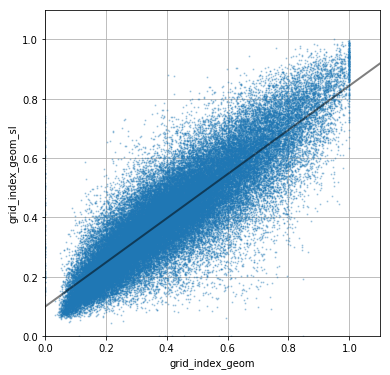

In [17]:
# moran plot to show spatial autocorrelation
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(x=df[response], y=df[response_sl], s=1, alpha=0.3, zorder=2)

x_line = np.array((-1e9, 1e9))
y_line = m * x_line + b
ax.plot(x_line, y_line, c='k', alpha=0.5, linewidth=2, zorder=3)

ax.grid(True)
ax.set_xlabel(response)
ax.set_ylabel(response_sl)
ax.set_xlim((df[response].min(), df[response].max()*1.1))
ax.set_ylim((df[response_sl].min(), df[response_sl].max()*1.1))
plt.show()

In [18]:
def make_table(model):

    table = pd.DataFrame()
    
    params = model.betas[:, 0]
    z_values = [z for z, p in model.z_stat]
    p_values = [p for z, p in model.z_stat]
    
    #table['z'] = z_values
    table['se'] = gmm.std_err
    table['se'] = table['se'].map(lambda x: '<0.0001' if abs(x) < 0.0001 else f'{x:.4f}')

    table['params'] = params
    table['params'] = table['params'].map(lambda x: '<0.0001' if abs(x) < 0.0001 else f'{x:.4f}')

    table['p'] = p_values
    def significance(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '** '
        elif p < 0.05:
            return '*  '
        else:
            return '   '

    table['params'] = table.apply(lambda row: '{}{}'.format(row['params'], significance(row['p'])), axis=1)
    table = table.drop(columns=['p']).reindex(columns=['params', 'se'])
    table.index = model.name_x + ['spatial_lag_rho', 'spatial_error_lambda']
    return table

## Estimate Spatial Models

GMM method for a spatial lag and error model with heteroskedasticity and endogenous variables, with results and diagnostics; based on Arraiz et al [Arraiz2010], following Anselin [Anselin2011].

https://pysal.readthedocs.io/en/latest/library/spreg/error_sp_het.html#pysal.spreg.error_sp_het.GM_Combo_Het

## Model 1

primary: estimates model 1 from other notebook via GMM instead of OLS

In [45]:
# create design matrix containing predictors (drop nulls), and a response variable matrix with 1 column
predictors = physical_predictors + sorted(era_primary_dummies) + sorted(state_dummies)
X = df[predictors]
Y = df[[response]]
X.columns = [c.replace('dummy_primary_prop_', 'primary_')  if 'dummy_primary_prop_' in c else c for c in X.columns]

In [46]:
print(W.n)
print(Y.shape)
print(X.shape)

72082
(72082, 1)
(72082, 69)


In [47]:
%%time
# first check ols diagnostics to see nature of spatial dependence
ols = pysal.spreg.ols.OLS(y=Y.values, x=X.values, w=W, spat_diag=True, moran=True)

C:\Anaconda\envs\ox\lib\site-packages\pysal\spreg\diagnostics.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  ci_result = sqrt(max_eigval / min_eigval)


Wall time: 1.34 s


In [48]:
# moran's i, standardized i, p-value
# lm stat, p-value
print(ols.moran_res)
print(ols.lm_error)
print(ols.rlm_error)
print(ols.lm_lag)
print(ols.rlm_lag)

(0.3715719991755811, 170.64232671937134, 0.0)
(28899.80781323553, 0.0)
(5346.637000163448, 0.0)
(28606.867908192617, 0.0)
(5053.697095120537, 0.0)


In [49]:
%%time
gmm = pysal.spreg.error_sp_het.GM_Combo_Het(y=Y.values, x=X.values, w=W, name_w='W',
                                            name_x=X.columns.tolist(), name_y=response)

Wall time: 1.82 s


In [50]:
print(gmm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES (HET)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :           W
Dependent Variable  :grid_index_geom                Number of Observations:       72082
Mean dependent var  :      0.4216                Number of Variables   :          71
S.D. dependent var  :      0.2088                Degrees of Freedom    :       72011
Pseudo R-squared    :      0.8160
Spatial Pseudo R-squared:  0.7403
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.1277609       0.0181416      -7.0424447       0.0000000
               aland  

In [51]:
table1 = make_table(gmm)
table1.tail()

,params,se
WI,0.1107***,0.0093
WV,0.0960***,0.0103
WY,0.1576***,0.0150
spatial_lag_rho,0.4492***,0.0097
spatial_error_lambda,0.3327***,0.0102


## Model 2

plurality: estimates model 2 from other notebook via GMM instead of OLS

In [26]:
# create design matrix containing predictors (drop nulls), and a response variable matrix with 1 column
predictors = physical_predictors + sorted(era_plurality_dummies) + sorted(state_dummies)
X = df[predictors]
Y = df[[response]]
X.columns = [c.replace('dummy_plurality_prop_', 'plurality_')  if 'dummy_plurality_prop_' in c else c for c in X.columns]

In [27]:
print(W.n)
print(Y.shape)
print(X.shape)

72082
(72082, 1)
(72082, 69)


In [28]:
%%time
# first check ols diagnostics to see nature of spatial dependence
ols = pysal.spreg.ols.OLS(y=Y.values, x=X.values, w=W, spat_diag=True, moran=True)

Wall time: 1.16 s


In [29]:
# moran's i, standardized i, p-value
# lm stat, p-value
print(ols.moran_res)
print(ols.lm_error)
print(ols.rlm_error)
print(ols.lm_lag)
print(ols.rlm_lag)

(0.37221132005688395, 170.9361212421312, 0.0)
(28999.342469309522, 0.0)
(5495.765126632169, 0.0)
(28393.919857365327, 0.0)
(4890.342514687977, 0.0)


In [30]:
%%time
gmm = pysal.spreg.error_sp_het.GM_Combo_Het(y=Y.values, x=X.values, w=W, name_w='W',
                                            name_x=X.columns.tolist(), name_y=response)

Wall time: 2.15 s


In [31]:
print(gmm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES (HET)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :           W
Dependent Variable  :grid_index_geom                Number of Observations:       72082
Mean dependent var  :      0.4216                Number of Variables   :          71
S.D. dependent var  :      0.2088                Degrees of Freedom    :       72011
Pseudo R-squared    :      0.8156
Spatial Pseudo R-squared:  0.7403
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.1201843       0.0183575      -6.5468860       0.0000000
               aland  

In [32]:
table2 = make_table(gmm)
table2.tail()

,params,se
WI,0.1116***,0.0094
WV,0.0979***,0.0104
WY,0.1583***,0.0151
spatial_lag_rho,0.4445***,0.0098
spatial_error_lambda,0.3405***,0.0101


## Model 3

majority: estimates model 3 from other notebook via MLE instead of OLS and includes spatial lag term

In [33]:
# only retain units with majority (rather than plurality) built in decade
c = ['prop_1939_earlier', 'prop_1940_49', 'prop_1950_59', 'prop_1960_69', 'prop_1970_79', 'prop_1980_89', 'prop_1990_99', 'prop_2000_09', 'prop_2010_later']
mask = (df[c] > 0.5).apply(sum, axis=1).astype(bool)
sum(mask)

12840

In [34]:
# create design matrix containing predictors (drop nulls), and a response variable matrix with 1 column
predictors = physical_predictors + sorted(era_majority_dummies) + sorted(state_dummies)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=predictors)
Y = df[mask][[response]]
X = df[mask][predictors]

# must remove any vars that are constant (ie, all zeros) as pysal demands no constant vectors
# this happens because some states have no units with majority built in single decade
drop = X.columns[X.sum()==0]
X = X.drop(columns=drop)
print(drop)

X.columns = [c.replace('dummy_majority_prop_', 'majority_')  if 'dummy_majority_prop_' in c else c for c in X.columns]

Index([], dtype='object')


In [35]:
# avoid a singular matrix by dropping alaska rows (too few observations)
X = X[X['AK'] != 1].drop(columns='AK')
Y = Y.reindex(X.index)

In [36]:
%%time
# recalculate weights matrix for this reduced set of units
gdf3 = gdf.reindex(Y.index)
W3 = pysal.weights.Contiguity.Queen.from_dataframe(gdf3)
W.transform = 'r'

Wall time: 11 s


C:\Anaconda\envs\ox\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 1861 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Anaconda\envs\ox\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 01003010703, 01073005905, 01073010803, 01073011210, 01073013200, 01073014302, 01073014408, 01081042005, 01097003706, 01101005302, 01101005408, 01101005409, 01101005609, 01101006100, 01103000800, 04003001402, 04013093101, 04013103306, 04013107202, 04013108200, 04013109101, 04013109300, 04013110001, 04013111401, 04013112201, 04013114301, 04013217002, 04013217204, 04013318501, 04013318700, 04013319705, 04013420303, 04013422105, 04013940700, 04015951502, 04015953900, 04019000900, 04019003400, 04019004067, 04019004334, 04019004647, 04019004722, 04021000700, 04021001100, 04021001701, 04023966103, 04025000204, 04025000604, 04027011108, 04027011115, 04027011406, 04027011504, 05007020305, 05007021308, 05085020101, 0511900

In [37]:
# is our response significantly correlated with avg values in neighborhood?
mi3 = pysal.Moran(y=Y.values, w=W3, two_tailed=True)
print(mi3.I)
print(mi3.p_sim)

('WARNING: ', '01003010703', ' is an island (no neighbors)')
('WARNING: ', '01073005905', ' is an island (no neighbors)')
('WARNING: ', '01073010803', ' is an island (no neighbors)')
('WARNING: ', '01073011210', ' is an island (no neighbors)')
('WARNING: ', '01073013200', ' is an island (no neighbors)')
('WARNING: ', '01073014302', ' is an island (no neighbors)')
('WARNING: ', '01073014408', ' is an island (no neighbors)')
('WARNING: ', '01081042005', ' is an island (no neighbors)')
('WARNING: ', '01097003706', ' is an island (no neighbors)')
('WARNING: ', '01101005302', ' is an island (no neighbors)')
('WARNING: ', '01101005408', ' is an island (no neighbors)')
('WARNING: ', '01101005409', ' is an island (no neighbors)')
('WARNING: ', '01101005609', ' is an island (no neighbors)')
('WARNING: ', '01101006100', ' is an island (no neighbors)')
('WARNING: ', '01103000800', ' is an island (no neighbors)')
('WARNING: ', '04003001402', ' is an island (no neighbors)')
('WARNING: ', '040130931

In [38]:
print(W3.n)
print(Y.shape)
print(X.shape)

12837
(12837, 1)
(12837, 68)


In [39]:
%%time
gmm = pysal.spreg.error_sp_het.GM_Combo_Het(y=Y.values, x=X.values, w=W3, name_w='W3',
                                            name_x=X.columns.tolist(), name_y=response)

Wall time: 392 ms


In [40]:
print(gmm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES (HET)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :          W3
Dependent Variable  :grid_index_geom                Number of Observations:       12837
Mean dependent var  :      0.5124                Number of Variables   :          70
S.D. dependent var  :      0.2246                Degrees of Freedom    :       12767
Pseudo R-squared    :      0.7354
Spatial Pseudo R-squared:  0.7170
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.2169315       0.0395066       5.4910172       0.0000000
               aland  

In [41]:
table3 = make_table(gmm)

## Model 4

only tracts with at least one decade of at least 20%, and identified by earliest such decade

In [52]:
mask = pd.notnull(df['earliest_decade'])
sum(mask)

68306

In [53]:
# create design matrix containing predictors (drop nulls), and a response variable matrix with 1 column
predictors = physical_predictors + sorted(era_earliest_dummies) + sorted(state_dummies)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=predictors)
Y = df[mask][[response]]
X = df[mask][predictors]

# must remove any vars that are constant (ie, all zeros) as pysal demands no constant vectors
# this happens because some states have no units with majority built in single decade
drop = X.columns[X.sum()==0]
X = X.drop(columns=drop)
print(drop)

X.columns = [c.replace('dummy_earliest_', 'earliest_')  if 'dummy_earliest_' in c else c for c in X.columns]

Index([], dtype='object')


In [54]:
%%time
# recalculate weights matrix for this reduced set of units
gdf4 = gdf.reindex(Y.index)
W4 = pysal.weights.Contiguity.Queen.from_dataframe(gdf4)
W.transform = 'r'

Wall time: 3min 37s


C:\Anaconda\envs\ox\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 69 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Anaconda\envs\ox\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 02180000200, 05053470400, 06055201601, 06097154303, 08055960600, 12087980100, 15009031601, 18143966800, 20209042600, 22009030400, 22041950300, 23019030000, 24029950500, 25001010100, 25001010306, 25023560100, 25027726200, 26009960400, 26021021300, 26029000500, 26031960200, 26065004403, 26083980100, 27053027202, 27071790100, 27137015300, 28019950300, 29095013902, 29127960300, 29155470300, 29186960200, 34033020800, 34041032000, 36029015401, 36029015900, 36055014901, 36081107201, 36111953500, 37047930300, 38053962400, 38057961600, 40073958300, 40085094100, 40093955300, 40105172400, 42009960700, 42013010401, 42027011100, 42043025400, 42079216501, 44005041300, 44009041500, 47169090200, 48035950200, 48059030101, 480939503

In [55]:
# is our response significantly correlated with avg values in neighborhood?
mi4 = pysal.Moran(y=Y.values, w=W4, two_tailed=True)
print(mi4.I)
print(mi4.p_sim)

('WARNING: ', '02180000200', ' is an island (no neighbors)')
('WARNING: ', '05053470400', ' is an island (no neighbors)')
('WARNING: ', '06055201601', ' is an island (no neighbors)')
('WARNING: ', '06097154303', ' is an island (no neighbors)')
('WARNING: ', '08055960600', ' is an island (no neighbors)')
('WARNING: ', '12087980100', ' is an island (no neighbors)')
('WARNING: ', '15009031601', ' is an island (no neighbors)')
('WARNING: ', '18143966800', ' is an island (no neighbors)')
('WARNING: ', '20209042600', ' is an island (no neighbors)')
('WARNING: ', '22009030400', ' is an island (no neighbors)')
('WARNING: ', '22041950300', ' is an island (no neighbors)')
('WARNING: ', '23019030000', ' is an island (no neighbors)')
('WARNING: ', '24029950500', ' is an island (no neighbors)')
('WARNING: ', '25001010100', ' is an island (no neighbors)')
('WARNING: ', '25001010306', ' is an island (no neighbors)')
('WARNING: ', '25023560100', ' is an island (no neighbors)')
('WARNING: ', '250277262

In [56]:
print(W4.n)
print(Y.shape)
print(X.shape)

68306
(68306, 1)
(68306, 69)


In [57]:
%%time
gmm = pysal.spreg.error_sp_het.GM_Combo_Het(y=Y.values, x=X.values, w=W4, name_w='W4',
                                            name_x=X.columns.tolist(), name_y=response)

Wall time: 1.7 s


In [58]:
print(gmm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES (HET)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :          W4
Dependent Variable  :grid_index_geom                Number of Observations:       68306
Mean dependent var  :      0.4258                Number of Variables   :          71
S.D. dependent var  :      0.2094                Degrees of Freedom    :       68235
Pseudo R-squared    :      0.8108
Spatial Pseudo R-squared:  0.7398
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0971404       0.0195431      -4.9705820       0.0000007
               aland  

In [59]:
table4 = make_table(gmm)

## Merge result tables and save to disk

In [60]:
table = pd.concat((table1, table2, table3, table4), axis=1, sort=False).fillna('')
table.to_csv('data/table-gmm-models.csv', index=True, encoding='utf-8')

In [61]:
table

,params,se,params,se,params,se,params,se
CONSTANT,-0.1278***,0.0181,-0.1202***,0.0184,0.2169***,0.0395,-0.0971***,0.0195
aland,<0.0001***,<0.0001,<0.0001***,<0.0001,<0.0001,<0.0001,<0.0001***,<0.0001
total_pop_k,-0.0055***,0.0002,-0.0054***,0.0002,-0.0031***,0.0004,-0.0052***,0.0002
is_urban,0.0168***,0.0012,0.0151***,0.0012,0.0223***,0.0048,0.0156***,0.0012
prop_single_fam,-0.0035,0.0027,-0.0029,0.0027,-0.0597***,0.0069,-0.0042,0.0028
med_rooms_per_home,-0.0145***,0.0006,-0.0153***,0.0006,-0.0108***,0.0015,-0.0149***,0.0006
intersect_density,0.0003***,<0.0001,0.0003***,<0.0001,0.0002***,<0.0001,0.0003***,<0.0001
length_mean,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001,<0.0001
prop_deadend,-0.1897***,0.0118,-0.1839***,0.0119,-0.3419***,0.0246,-0.1983***,0.0121
k_avg,0.1794***,0.0043,0.1805***,0.0043,0.1164***,0.0082,0.1733***,0.0044
